In [1]:
# auto reload notebook
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import sofar as sfr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import platform

from pathlib import Path
from tqdm import tqdm

import h5py

from pprint import pprint
from einops import rearrange

import pyroomacoustics as pra

In [3]:
from shamans.utils.math_utils import sph2cart, cart2sph

def get_easycom_array(chans=None):
    R_3M = np.array(
        [
            [+0.082, +0.005, -0.029],
            [-0.001, +0.001, +0.030],
            [-0.077, +0.002, +0.011],
            [-0.083, +0.005, -0.060],
            [+0.052, +0.010, -0.060],
            [-0.053, +0.005, -0.060],
        ]
    ).T
    R_3M = R_3M[[2, 0, 1], :] - np.array([[-0.07, 0.0, 0.0]]).T
    return R_3M[:, chans] if chans is not None else R_3M

# Make NSteerer's SPEAR reference

In [114]:
data_path_v2 = Path('../data/Device_ATFs_v2.h5')
data_h5_v2 = h5py.File(data_path_v2)
data_h5 = data_h5_v2

phy = {
    'R' : 1.5,
    'r' : 0.09,
    'c' : 343,
}

AIR = data_h5['IR'][()]
nTime, nDoas, nChan = AIR.shape
azi = data_h5['Phi'][()].T
inc = data_h5['Theta'][()].T
ele = np.pi / 2 - inc

fs = data_h5['SamplingFreq_Hz'][()][0,0]
print('Sampling Frequency:', fs)
dirs = np.concatenate((azi, inc), axis=1)

phi = azi = np.sort(np.unique(azi))
ele = np.sort(np.unique(ele))
theta = inc = np.sort(np.unique(inc))
nPhi = nAzi = len(azi)
nTheta = nEle = len(ele)

nfft = 768
ATF = np.fft.rfft(AIR, n=nfft, axis=0)
freqs = np.fft.rfftfreq(nfft, 1 / fs)
print(ATF.shape)

nFreq, nDoas, nChan = ATF.shape

freqs = np.fft.rfftfreq(nfft, 1/fs).squeeze()
chans = np.arange(nChan)

print(freqs.shape, dirs.shape, chans.shape)

nFreq = len(freqs)
nDirs = len(dirs)
nChans = len(chans)

print('Dimensions', nFreq, nDirs, nChans)

coords_mesh = np.stack(np.meshgrid(
    freqs, theta, phi, chans, indexing="ij"), -1)
coords = rearrange(coords_mesh, 'f th ph c v-> f (th ph) c v')

print('Coords:', coords.shape)
print('Target:', ATF.shape)

Sampling Frequency: 48000.0
(385, 1020, 6)
(385,) (1020, 2) (6,)
Dimensions 385 1020 6
Coords: (385, 1020, 6, 4)
Target: (385, 1020, 6)


In [115]:
atfs_mesh = ATF.reshape(nFreq, nPhi, nTheta, nChan)  # [nTime x nPhi x nTheta x nChan]
atfs_mesh = atfs_mesh.transpose([0, 2, 1, 3])  # [nTime x nTheta x nPhi x nChan]

airs_mesh = AIR.reshape(nTime, nPhi, nTheta, nChan)  # [nTime x nPhi x nTheta x nChan]
airs_mesh = airs_mesh.transpose([0, 2, 1, 3])  # [nTime x nTheta x nPhi x nChan]

coords_mesh = coords.reshape(nFreq, nTheta, nPhi, nChan, 4)

airs_fdc = rearrange(airs_mesh, 't th ph c -> t (th ph) c')
atfs_fdc = rearrange(atfs_mesh, 'f th ph c -> f (th ph) c')
coords_fdc = rearrange(coords_mesh, 'f th ph c v -> f (th ph) c v')

print('ATFs:', atfs_fdc.shape)
print('AIRs:', airs_fdc.shape)

atfs_fdc_ = np.fft.rfft(airs_fdc, n=nfft, axis=0)
assert np.allclose(atfs_fdc, atfs_fdc_)

mic_pos_easycom = get_easycom_array()
print(mic_pos_easycom)

ATFs: (385, 1020, 6)
AIRs: (768, 1020, 6)
[[ 0.041  0.1    0.081  0.01   0.01   0.01 ]
 [ 0.082 -0.001 -0.077 -0.083  0.052 -0.053]
 [ 0.005  0.001  0.002  0.005  0.01   0.005]]


In [134]:
# load full ATF from oracle measurements (1020) in pickle format
path_to_spear_measuments = '../data/models/ref_nObs-8_seed-13.pkl'
with open(path_to_spear_measuments, 'rb') as f:
    atf_ref_dict = pickle.load(f)
    
print(atf_ref_dict.keys())

print(atf_ref_dict['format'])

print(atf_ref_dict['svects'].shape)
print(coords.shape)

dirs_atf_ref = coords[0,:,0,1:3]
print(dirs_atf_ref)

assert np.allclose(dirs_atf_ref, coords_fdc[0,:,0,1:3])
nFreq = atf_ref_dict['svects'].shape[0]
assert np.allclose(atf_ref_dict['svects'], atfs_fdc[:nFreq])

dict_keys(['format', 'coords', 'svects', 'nObs', 'seed', 'sv_method', 'nfft', 'fs'])
freq,doa,chan
(129, 1020, 6)
(385, 1020, 6, 4)
[[0.10471976 0.        ]
 [0.10471976 0.10471976]
 [0.10471976 0.20943951]
 ...
 [2.72271363 5.96902604]
 [2.72271363 6.0737458 ]
 [2.72271363 6.17846555]]


In [135]:
print(airs_fdc.shape)
airs_mRn = rearrange(airs_fdc, 'time doas chan -> doas chan time')
atfs_mRn = rearrange(atfs_fdc, 'freq doas chan -> doas chan freq')
print(airs_mRn.shape)
print(atfs_mRn.shape)

(768, 1020, 6)
(1020, 6, 768)
(1020, 6, 385)


In [142]:
sofa = sfr.Sofa('SimpleFreeFieldHRIR')

# get rirs
sofa.GLOBAL_Title = f'SPEAR_Kemar'

sofa.GLOBAL_DateCreated = '2025-03-08'

sofa.GLOBAL_AuthorContact = 'diego.dicarlo89@gmail.com'
sofa.GLOBAL_Organization = 'RIKEN AIP, Kyoto (JP)'
sofa.GLOBAL_License = 'The MIT License (MIT) Copyright (c) 2019, Diego Di Carlo. Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.'
sofa.GLOBAL_ApplicationName = 'Python'
sofa.GLOBAL_ApplicationVersion = platform.python_version()


sofa.GLOBAL_Comment = """
    ATFs recorded for the SPEAR Challenge.
    More information at https://imperialcollegelondon.github.io/spear-challenge/
"""

sofa.GLOBAL_History = """
    - 2025-03-08: Creation
"""

## --- RIRS --- ##
airs_mRn = airs_mRn # must be in M x R x N (measurements, receivers, samples, emitters)
sofa.Data_IR = airs_mRn
sofa.Data_SamplingRate = fs

## --- ReceiverPosition ##
# sofa.ReceiverPosition = get_easycom_array().T # nChan x 3
sofa.ReceiverPosition = np.zeros_like(get_easycom_array().T) # nChan x 3


## --- SourcePosition ##
distance = np.array([1.4] * nDoas)
azimuth = np.rad2deg(dirs_atf_ref[:,1])
elevation = np.rad2deg(np.pi /2 - dirs_atf_ref[:,0])
sofa.SourcePosition = np.array([azimuth, elevation, distance]).T # nDoas x 3
print(sofa.SourcePosition.shape)
print(sofa.SourcePosition.max(0))

sofa.Data_Delay = np.ones((1, nChans)) * 1.4 / phy['c']

filename = sofa.GLOBAL_Title
path_to_out = Path(f'../data/{filename}_rir2.sofa')

sofa.verify()
sofa.list_dimensions

print(path_to_out)
sfr.write_sofa(path_to_out, sofa)

(1020, 3)
[354.   84.    1.4]
R = 6 receiver (set by ReceiverPosition of dimension RCI, RCM)
E = 1 emitter (set by EmitterPosition of dimension ECI, ECM)
M = 1020 measurements (set by Data_IR of dimension MRN)
N = 768 samples (set by Data_IR of dimension MRN)
C = 3 coordinate dimensions, fixed
I = 1 single dimension, fixed
S = 0 maximum string length

../data/SPEAR_Kemar_rir2.sofa


In [143]:
# load sfr file
sofa = sfr.read_sofa(path_to_out)

In [144]:
# The desired reverberation time and dimensions of the room
fs = 48000 # int(fs)
rt60 = 0.2  # seconds
room_dim = [6, 4, 3]  # meters

energy_absorption, max_order = pra.inverse_sabine(rt60, room_dim)
max_order = 0

array_center = [1.05, 1.74, 1.81]
# provide the source position with respect to the microphone center
azimuth = 0
elevation = 90
distance = 1.4
src_pos = pra.doa.utils.spher2cart(azimuth, elevation, distance, degrees=True)
src_pos += array_center


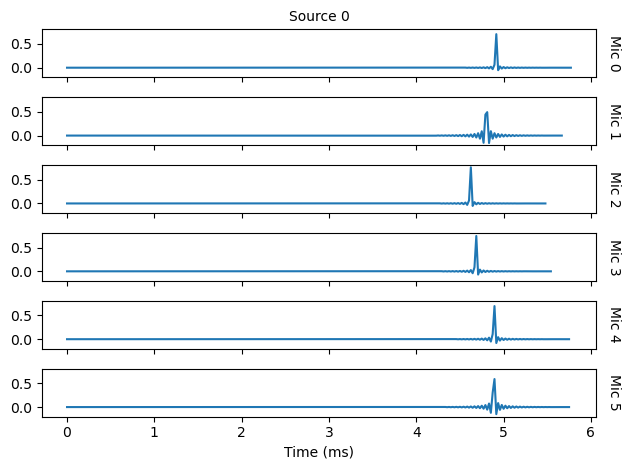

In [145]:
room = pra.ShoeBox(
    p=[5, 4, 3],
    materials=pra.Material(energy_absorption),
    fs=fs,
    max_order=max_order,
)


room.add_microphone(array_center)
room.add_microphone(array_center + mic_pos_easycom[:,0])
room.add_microphone(array_center + mic_pos_easycom[:,1])
room.add_microphone(array_center + mic_pos_easycom[:,2])
room.add_microphone(array_center + mic_pos_easycom[:,3])
room.add_microphone(array_center + mic_pos_easycom[:,4])


room.add_source(src_pos)

room.compute_rir()

rirs_free = room.rir

room.plot_rir()
plt.show()

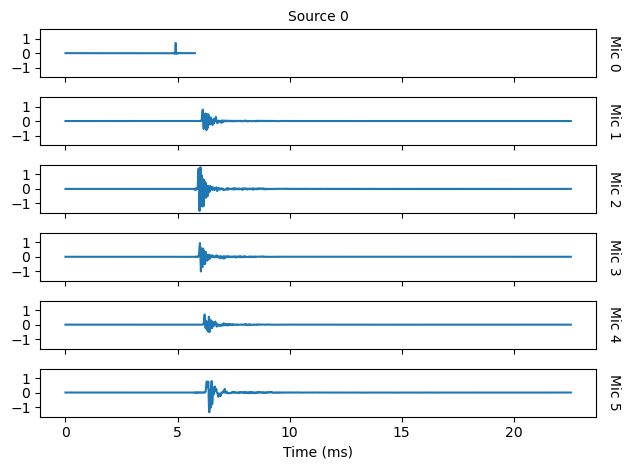

In [146]:
room = pra.ShoeBox(
    p=[5, 4, 3],
    materials=pra.Material(energy_absorption),
    fs=fs,
    max_order=max_order,
)

spear_array = pra.directivities.MeasuredDirectivityFile(
    path=path_to_out,  # SOFA file is in the database
    fs=room.fs,
    interp_order=None,  # interpolation order
    interp_n_points=1000,  # number of points in the interpolation grid
)
# Create a rotation object to orient the microphones.
rot_obj = pra.direction.Rotation3D([0, 0, 0], "xyz", degrees=True)

dir_obj_m1 = spear_array.get_mic_directivity(0, orientation=rot_obj)
dir_obj_m2 = spear_array.get_mic_directivity(1, orientation=rot_obj)
dir_obj_m3 = spear_array.get_mic_directivity(2, orientation=rot_obj)
dir_obj_m4 = spear_array.get_mic_directivity(3, orientation=rot_obj)
dir_obj_m5 = spear_array.get_mic_directivity(4, orientation=rot_obj)


# for a head-related transfer function, the microphone should be co-located
mic_pos = [1.05, 1.74, 1.81]
room.add_microphone(mic_pos)
room.add_microphone(mic_pos, directivity=dir_obj_m1)
room.add_microphone(mic_pos, directivity=dir_obj_m2)
room.add_microphone(mic_pos, directivity=dir_obj_m3)
room.add_microphone(mic_pos, directivity=dir_obj_m4)
room.add_microphone(mic_pos, directivity=dir_obj_m5)

# provide the source position with respect to the microphone center
room.add_source(src_pos)

room.compute_rir()
rirs_spear = room.rir
room.plot_rir()
plt.show()

540


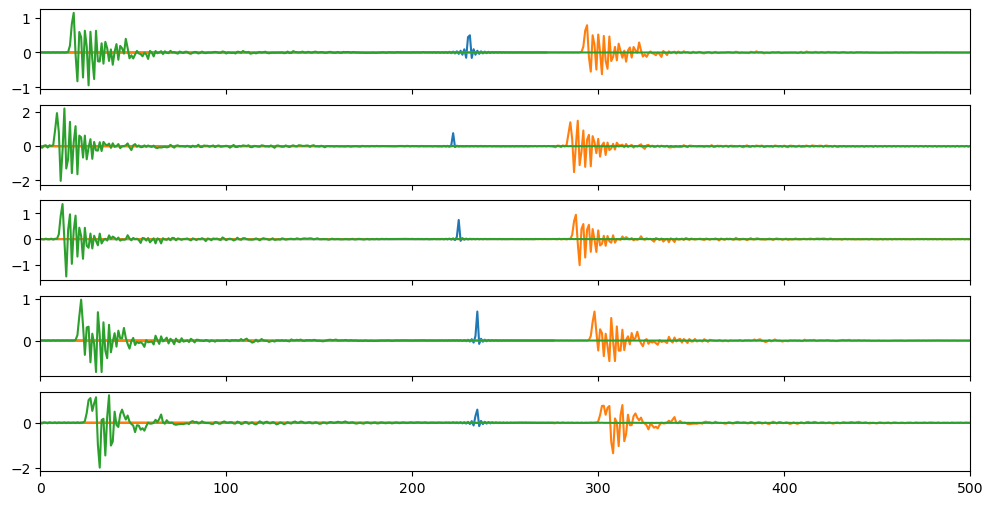

In [148]:
idx_az0_el0 = np.where((dirs_atf_ref[:,1] == 0) & (dirs_atf_ref[:,0] == np.pi/2))[0][0]
print(idx_az0_el0)


fig, axarr = plt.subplots(nChan-1, 1, figsize=(12, 6), sharex=True)
for i in range(nChan-1):
    axarr[i].plot(rirs_free[i+1][0], label='Free')
    axarr[i].plot(rirs_spear[i+1][0], label='SPEAR')
    axarr[i].plot(airs_mRn[idx_az0_el0,i,:], label='Oracle')
plt.xlim([0, 500])
plt.show()